Populating the interactive namespace from numpy and matplotlib
Ni_Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px']
O2_orbs =  ['py']
compute A(w) for symmetries =  ['1A1', '1B1', '3B1', '1A2', '3A2', '1E', '3E']
Mc= 2
VS.dim =  5308
len(d_list) 1820
len(p_list) 272
ANi= 0.0 ACu= 0.0 epCu= 3.0 epNi= 7.0  tpd= 0.01  tpp= 0.55  Upp= 0 tz= 0.0
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_tz_matrix
start create_edep_diag_matrix
start create_interaction_matrix
--- create_interaction_matrix_ALL_syms 0.9963335990905762 seconds ---
a1a1_state_indices 4220 , state: orb=  up d3z2r2 0 0 1 dn d3z2r2 0 0 0 dn px 1 0 1
a1a1_state_indices 4221 , state: orb=  dn d3z2r2 0 0 1 up d3z2r2 0 0 0 dn px 1 0 1
a1a1_state_indices 4222 , state: orb=  up d3z2r2 0 0 1 up d3z2r2 0 0 0 dn px 1 0 1
a1a1_state_indices 4223 , state: orb=  dn d3z2r2 0 0 1 dn d3z2r2 0 0 0 up px 1 0 1
a1a1_state_indices 4224 , state: orb=  up d3z2r2 0 0 1 dn d3z2r2 0 0 0 up px 1 0 1
a1a1_state_in

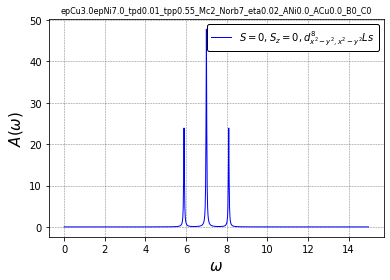

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import basis_change_old as basis2
import get_state as getstate
import utility as util
import plotfig as fig
import ground_state as gs
import lanczos
import time
start_time = time.time()
M_PI = math.pi
                  
#####################################
def compute_Aw_main(ANi,ACu,epCu,epNi,tpd,tpp,tz,pds,pdp,pps,ppp,Upp,\
                    d_double,p_double,double_part, idx, hole3_part,U, S_val, Sz_val, AorB_sym):  
    if Norb==7:
        fname = 'epCu'+str(epCu)+'epNi'+str(epNi)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
                  +'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta) +'_ANi'+str(ANi) \
                  + '_ACu'+str(ACu) + '_B'+str(B) + '_C'+str(C)                   
        flowpeak = 'Norb'+str(Norb)+'_tpp'+str(tpp)+'_Mc'+str(Mc)+'_eta'+str(eta)
    elif Norb==9 or Norb==10 or Norb==11:
        fname = 'epCu'+str(epCu)+'epNi'+str(epNi)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
                  +'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta) \
                  +'_ANi'+str(ANi) + '_ACu'+str(ACu) + '_B'+str(B) + '_C'+str(C)
        flowpeak = 'Norb'+str(Norb)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_Mc'+str(Mc)+'_eta'+str(eta) 
               
                
    w_vals = np.arange(pam.wmin, pam.wmax, pam.eta)
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))

    # set up H0
    if Norb==7:
        tpd_nn_hop_dir, tpd_orbs, tpd_nn_hop_fac, tpp_nn_hop_fac \
                                   = ham.set_tpd_tpp(Norb,tpd,tpp,0,0,0,0)
    elif Norb==9 or Norb==11:
        tpd_nn_hop_dir, tpd_orbs, tpd_nn_hop_fac, tpp_nn_hop_fac \
                                   = ham.set_tpd_tpp(Norb,0,0,pds,pdp,pps,ppp)
    
    tz_fac = ham.set_tz(Norb,tz)
            
    T_pd   = ham.create_tpd_nn_matrix(VS,tpd_nn_hop_dir, tpd_orbs, tpd_nn_hop_fac)
    T_pp   = ham.create_tpp_nn_matrix(VS,tpp_nn_hop_fac)  
    T_z    = ham.create_tz_matrix(VS,tz_fac)
    Esite  = ham.create_edep_diag_matrix(VS,ANi,ACu,epNi,epCu)      
    
    H0 = T_pd + T_pp + T_z + Esite     
    '''
    Below probably not necessary to do the rotation by multiplying U and U_d
    the basis_change.py is only for label the state as singlet or triplet
    and assign the interaction matrix
    '''
    if pam.if_H0_rotate_byU==1:
        H0_new = U_d.dot(H0.dot(U))
    
    clf()

    if Norb==7 or Norb==9 or Norb==10 or Norb==11:     
        Hint = ham.create_interaction_matrix_ALL_syms(VS,d_double,p_double,double_part, idx, hole3_part, \
                                                      S_val, Sz_val,AorB_sym, ACu, ANi, Upp)
        
        if pam.if_H0_rotate_byU==1:
            H = H0_new + Hint 
        else:
            H = H0 + Hint 
        H.tocsr()

        ####################################################################################
        # compute GS only for turning on full interactions
        if pam.if_get_ground_state==1:
            vals, vecs = gs.get_ground_state(H, VS, S_val, Sz_val)
#             if Norb==8:
#                 util.write_GS('Egs_'+flowpeak+'.txt',A,ep,tpd,vals[0])
#             elif Norb==10 or Norb==11 or Norb==12:
#                 util.write_GS2('Egs_'+flowpeak+'.txt',A,ep,pds,pdp,vals[0])
        #########################################################################
        '''
        Compute A(w) for various states
        '''
        if pam.if_compute_Aw==1:
#             # compute d8
#             fig.compute_Aw_d8_sym(H, VS, d_double, S_val, Sz_val, AorB_sym, A, w_vals, "Aw_d8_sym_", fname)

#             compute d9Ld9
            d9Ld9_a1b1_state_indices, d9Ld9_a1b1_state_labels, d9Ld9_b1a1_state_indices, d9Ld9_b1a1_state_labels, \
            d9Ld9_a1a1_state_indices, d9Ld9_a1a1_state_labels, d9Ld9_b1b1_state_indices, d9Ld9_b1b1_state_labels \
                    = getstate.get_d9Ld9_state_indices(VS,d_double,S_val, Sz_val)
            fig.compute_Aw1(H, VS, w_vals, d9Ld9_a1b1_state_indices, d9Ld9_a1b1_state_labels, "Aw_d9Ld9_a1b1_", fname)
            fig.compute_Aw1(H, VS, w_vals, d9Ld9_a1a1_state_indices, d9Ld9_a1a1_state_labels, "Aw_d9Ld9_a1a1_", fname)
            fig.compute_Aw1(H, VS, w_vals, d9Ld9_b1b1_state_indices, d9Ld9_b1b1_state_labels, "Aw_d9Ld9_b1b1_", fname)            

# #             # compute d9d9L
#             d9d9L_a1b1_state_indices, d9d9L_a1b1_state_labels, d9d9L_b1a1_state_indices, d9d9L_b1a1_state_labels, \
#             d9d9L_a1a1_state_indices, d9d9L_a1a1_state_labels, d9d9L_b1b1_state_indices, d9d9L_b1b1_state_labels \
#                     = getstate.get_d9d9L_state_indices(VS,d_double,S_val, Sz_val)
#             fig.compute_Aw1(H, VS, w_vals, d9d9L_a1b1_state_indices, d9d9L_a1b1_state_labels, "Aw_d9d9L_a1b1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d9d9L_a1a1_state_indices, d9d9L_a1a1_state_labels, "Aw_d9d9L_a1a1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d9d9L_b1b1_state_indices, d9d9L_b1b1_state_labels, "Aw_d9d9L_b1b1_", fname) 
            
#             # compute d8d10L
#             d8d10L_a1b1_S0_state_indices, d8d10L_a1b1_S0_state_labels, d8d10L_a1b1_S1_Sz1_state_indices,\
#             d8d10L_a1b1_S1_Sz1_state_labels, d8d10L_a1b1_S1_Sz0_state_indices, d8d10L_a1b1_S1_Sz0_state_labels,\
#             d8d10L_a1b1_S1_Sz_1_state_indices, d8d10L_a1b1_S1_Sz_1_state_labels, d8d10L_b1b1_state_indices,\
#             d8d10L_b1b1_state_labels\
#                     = getstate.get_d8d10L_state_indices(VS,d_double,S_val, Sz_val)
#             fig.compute_Aw1(H, VS, w_vals, d8d10L_a1b1_S0_state_indices, d8d10L_a1b1_S0_state_labels, "Aw_d8d10L_a1b1_S0_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d8d10L_a1b1_S1_Sz1_state_indices, d8d10L_a1b1_S1_Sz1_state_labels, "Aw_d8d10L_a1b1_S1_Sz1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d8d10L_a1b1_S1_Sz0_state_indices, d8d10L_a1b1_S1_Sz0_state_labels, "Aw_d8d10L_a1b1_S1_Sz0_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d8d10L_a1b1_S1_Sz_1_state_indices, d8d10L_a1b1_S1_Sz_1_state_labels, "Aw_d8d10L_a1b1_S1_Sz_1_", fname) 
#             fig.compute_Aw1(H, VS, w_vals, d8d10L_b1b1_state_indices, d8d10L_b1b1_state_labels, "Aw_d8d10L_b1b1", fname)
                            
# #             # compute d8Ld10
#             d8Ld10_a1b1_S0_state_indices, d8Ld10_a1b1_S0_state_labels\
#                      = getstate. get_d8Ld10_state_indices(VS,d_double,S_val, Sz_val)    
#             fig.compute_Aw1(H, VS, w_vals, d8Ld10_a1b1_S0_state_indices, d8Ld10_a1b1_S0_state_labels, "Aw_d8Ld10_a1b1_S0_", fname)                

#             # compute d10Ld8
#             d10Ld8_a1b1_S0_state_indices, d10Ld8_a1b1_S0_state_labels, d10Ld8_a1b1_S1_Sz1_state_indices,\
#             d10Ld8_a1b1_S1_Sz1_state_labels, d10Ld8_a1b1_S1_Sz0_state_indices, d10Ld8_a1b1_S1_Sz0_state_labels,\
#             d10Ld8_a1b1_S1_Sz_1_state_indices, d10Ld8_a1b1_S1_Sz_1_state_labels, d10Ld8_b1b1_state_indices,\
#             d10Ld8_b1b1_state_labels\
#                     = getstate.get_d10Ld8_state_indices(VS,d_double,S_val, Sz_val)
#             fig.compute_Aw1(H, VS, w_vals, d10Ld8_a1b1_S0_state_indices, d10Ld8_a1b1_S0_state_labels, "Aw_d10Ld8_a1b1_S0_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d10Ld8_a1b1_S1_Sz1_state_indices, d10Ld8_a1b1_S1_Sz1_state_labels, "Aw_d10Ld8_a1b1_S1_Sz1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d10Ld8_a1b1_S1_Sz0_state_indices, d10Ld8_a1b1_S1_Sz0_state_labels, "Aw_d10Ld8_a1b1_S1_Sz0_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d10Ld8_a1b1_S1_Sz_1_state_indices, d10Ld8_a1b1_S1_Sz_1_state_labels, "Aw_d10Ld8_a1b1_S1_Sz_1_", fname) 
#             fig.compute_Aw1(H, VS, w_vals, d10Ld8_b1b1_state_indices, d10Ld8_b1b1_state_labels, "Aw_d10Ld8_b1b1", fname)
                            
# #             # compute d10d8L
#             d10d8L_a1b1_S0_state_indices, d10d8L_a1b1_S0_state_labels\
#                      = getstate. get_d10d8L_state_indices(VS,d_double,S_val, Sz_val)    
#             fig.compute_Aw1(H, VS, w_vals, d10d8L_a1b1_S0_state_indices, d10d8L_a1b1_S0_state_labels, "Aw_d10d8L_a1b1_S0_", fname)

              # compute d8d9
#             d8d9_a1b1a1_state_indices, d8d9_a1b1a1_state_labels, \
#             d8d9_a1b1b1_state_indices, d8d9_a1b1b1_state_labels, \
#             d8d9_a1a1b1_state_indices, d8d9_a1a1b1_state_labels \
#                          = getstate.get_d8d9_state_indices(VS,sym,d_double,S_val, Sz_val, AorB_sym, ANi)
#             fig.compute_Aw1(H, VS, w_vals, d8d9_a1b1a1_state_indices, d8d9_a1b1a1_state_labels, "Aw_d8d9_a1b1a1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d8d9_a1b1b1_state_indices, d8d9_a1b1b1_state_labels, "Aw_d8d9_a1b1b1_", fname)
#             fig.compute_Aw1(H, VS, w_vals, d8d9_a1a1b1_state_indices, d8d9_a1a1b1_state_labels, "Aw_d8d9_a1a1b1_", fname) 
     
    
#             fig.compute_Aw_d8d9_sym(H, VS, d_double, S_val, Sz_val, AorB_sym, ANi, w_vals, "Aw_d8d9_sym_", fname)
##########################################################################
if __name__ == '__main__': 
    Mc  = pam.Mc
    print ('Mc=',Mc)

    Norb = pam.Norb
    eta  = pam.eta
    edNi   = pam.edNi
    edCu   = pam.edCu

    ANis = pam.ANis
    ACus = pam.ACus
    B  = pam.B
    C  = pam.C
    
    # set up VS
    VS = vs.VariationalSpace(Mc)
#     basis.count_VS(VS)
    
    d_double, p_double, double_part, idx, hole3_part = ham.get_double_occu_list(VS)
    
    # change the basis for d_double states to be singlet/triplet
    if pam.basis_change_type=='all_states':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix \
                                    (VS, d_double, double_part, idx, hole3_part)
        if pam.if_print_VS_after_basis_change==1:
            basis.print_VS_after_basis_change(VS,S_val,Sz_val)
    elif pam.basis_change_type=='d_double':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix_d_double \
                                    (VS, d_double, double_part, idx, hole3_part)
#         U, S_val, Sz_val, AorB_sym = basis2.create_singlet_triplet_basis_change_matrix_d_double \
#                                     (VS,d_double)
    U_d = (U.conjugate()).transpose()
    # check if U if unitary
    #checkU_unitary(U,U_d)
    
    if Norb==7:
        for a in range(0,len(pam.tzs)):
            tz = pam.tzs[a] 
            for tpd in pam.tpds:
                for epCu in pam.epCus:
                    for epNi in pam.epNis:               
                        for ANi in pam.ANis:
                            for ACu in pam.ACus:
    #                            util.get_atomic_d8_energy(ANi,B,C)
                                for tpp in pam.tpps:
                                    for Upp in pam.Upps:
                                        print ('===================================================')
                                        print ('ANi=',ANi, 'ACu=',ACu,'epCu=', epCu, 'epNi=',epNi,\
                                               ' tpd=',tpd,' tpp=',tpp,' Upp=',Upp ,'tz=',tz)
                                        compute_Aw_main(ANi,ACu,epCu,epNi,tpd,tpp,tz,0,0,0,0,Upp,\
                                                        d_double,p_double,double_part, idx, hole3_part,U, \
                                                        S_val, Sz_val, AorB_sym)
    elif Norb==9 or Norb==10 or Norb==11:
        pps = pam.pps
        ppp = pam.ppp
        for a in range(0,len(pam.tzs)):
            tz = pam.tzs[a]                                        
            for ii in range(0,len(pam.pdps)):
                pds = pam.pdss[ii]
                pdp = pam.pdps[ii]
                for epCu in pam.epCus:
                    for epNi in pam.epNis:
                        for ANi in pam.ANis: 
                            for ACu in pam.ACus:
    #                         util.get_atomic_d8_energy(ANi,B,C)
                                for Upp in pam.Upps:
                                    print ('===================================================')
                                    print ('ANi=',ANi, 'ACu=',ACu,'epCu=',epCu, 'epNi=',epNi,' pds=',pds,\
                                           ' pdp=',pdp,' pps=',pps,' ppp=',ppp,' Upp=',Upp,'tz=',tz)
                                    compute_Aw_main(ANi,ACu,epCu,epNi,0,0,tz,pds,pdp,pps,ppp,Upp,\
                                                    d_double,p_double,double_part, idx, hole3_part, U, \
                                                    S_val, Sz_val, AorB_sym)

                        
    print("--- %s seconds ---" % (time.time() - start_time))